In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sciconsts
import scipy.fftpack as fft
import scipy.interpolate as sci_interpolate
import scipy.integrate as sci_integrate
import scipy.signal as signal
from mpl_toolkits.mplot3d import Axes3D
import time

In [178]:
''' caozhoujian function taylorT2'''
def chirp_mass(m1,m2):
    return np.power(m1*m2,0.6)/(np.power(m1+m2,0.2))
def sym_mass_ratio(m1,m2):
    return m1*m2/(np.power(m1+m2,2.0))
def F_cross(theta,psi,phi):
    return 0.5*(1+np.power(np.cos(theta),2))*np.cos(2*phi)*np.sin(2*psi)-np.cos(theta)*np.sin(2*phi)*np.cos(2*psi)
def F_plus(theta,psi,phi):
    return -0.5*(1+np.power(np.cos(theta),2))*np.cos(2.0*phi)*np.cos(2*psi)-np.cos(theta)*np.sin(2*phi)*np.sin(2*psi)
def D_eff(D,theta,psi,phi,iota):
    return D/(np.sqrt(np.power(F_cross(theta,psi,phi),2.0)*np.power(np.cos(iota),2.0)+np.power(F_plus(theta,psi,phi),2)*0.25*(1+np.power(np.cos(iota),2))))
def Psi(f,m_c,smr,D,theta,psi,phi,iota,t_c,phi_c,v_lso=1/np.sqrt(6.0)):
    Mcal=m_c/np.power(smr,0.6)
    v=np.power(sciconsts.pi*Mcal*f,1/3.0)
    return 2*sciconsts.pi*f*t_c-phi_c-sciconsts.pi*0.25+3.0/(128.0*smr*np.power(v,5.0))*(1+20/9.0*(743/336.0+11/4.0*smr)*np.power(v,2.0)-16.0*sciconsts.pi*np.power(v,3.0)+10.0*(3058673.0/1016064.0+5429/1008.0*smr+617.0/144.0*np.power(smr,2.0))*np.power(v,4.0)+sciconsts.pi*(38645.0/756.0-65/9.0*smr)*(1+3*np.log(v/v_lso))*np.power(v,5.0)+(11583231236531.0/4694215680.0+640.0/3.0*np.power(sciconsts.pi,2)-6848.0/21.0*0.57721566490153286060651209-6848/21.0*np.log(4.0*v)+(-15737765635.0/3048192+2255.0*np.power(sciconsts.pi,2.0)/12.0)*smr+76055.0/1728*np.power(smr,2.0)-127825/1296*np.power(smr,3.0))*np.power(v,6.0)+sciconsts.pi*(77096675.0/254016.0+378515.0/1512.0*smr-74045.0/756.0*np.power(smr,2.0))*np.power(v,7.0))
def h(f,m_c,smr,D,theta,psi,phi,iota,t_c,phi_c):
    return np.power(m_c,5.0/6.0)/D_eff(D,theta,psi,phi,iota)*np.power(f,-7.0/6.0)*np.exp(1.0j*Psi(f,m_c,smr,D,theta,psi,phi,iota,t_c,phi_c))

def Psi2(f,m_c,smr):
    Mcal2=m_c/np.power(smr,0.6)
    v=np.power(sciconsts.pi*Mcal2*f,1/3.0)
    return sciconsts.pi*0.25+3.0/(128.0*smr*np.power(v,5.0))*(1+20/9.0*(743/336.0+11/4.0*smr)*np.power(v,2.0)-16.0*sciconsts.pi*np.power(v,3.0)+10.0*(3058673.0/1016064.0+5429/1008.0*smr+617.0/144.0*np.power(smr,2.0))*np.power(v,4.0)+sciconsts.pi*(38645.0/756.0-65/9.0*smr)*(1+3*np.log(v*np.sqrt(6.0)))*np.power(v,5.0)+(11583231236531.0/4694215680.0+640.0/3.0*np.power(sciconsts.pi,2)-6848.0/21.0*0.57721566490153286060651209-6848/21.0*np.log(4.0*v)+(-15737765635.0/3048192+2255.0*np.power(sciconsts.pi,2.0)/12.0)*smr+76055.0/1728*np.power(smr,2.0)-127825/1296*np.power(smr,3.0))*np.power(v,6.0)+sciconsts.pi*(77096675.0/254016.0+378515.0/1512.0*smr-74045.0/756.0*np.power(smr,2.0))*np.power(v,7.0))

def h_mod(f,m_c,smr):
    return np.power(m_c,5.0/6.0)*np.power(f,-7.0/6.0)*np.exp(1.0j*Psi2(f,m_c,smr))*1e-48



    
'''MY FUNCTION PROJECT1'''
def k_1cal(m_1,m_2):
    return 64.0*np.power(sciconsts.G,3.0)*m_1*m_2*(m_1+m_2)/5.0/np.power(sciconsts.c,5.0)
def t_0cal(m_1,m_2,t_gas,a_0):
    return t_gas*0.25*np.log(k_1cal(m_1,m_2)+np.power(a_0,4.0)/t_gas)
def acal(t,k_1,t_gas,t_0):
    return np.power((np.exp(4.0*(t_0-t)/t_gas)-k_1)*t_gas,0.25)
def D1acal(t,k_1,t_gas,t_0):
    a1=acal(t,k_1,t_gas,t_0)
    return -k_1*np.power(a1,-3.0)-a1/t_gas
def D2acal(t,k_1,t_gas,t_0):
    a2=acal(t,k_1,t_gas,t_0)
    D1a2=D1acal(t,k_1,t_gas,t_0)
    return (3.0*k_1/np.power(a2,4.0)+1/t_gas)*D1a2
def Omegacal(t,k_1,t_gas,t_0,m_1,m_2):
    return np.power(sciconsts.G*(m_1+m_2)/np.power(acal(t,k_1,t_gas,t_0),3.0),0.5)
def D1Omegacal(t,k_1,t_gas,t_0,m_1,m_2):
    a3=acal(t,k_1,t_gas,t_0)
    D1a3=D1acal(t,k_1,t_gas,t_0)
    o1=Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    return -1.5*D1a3/a3*o1
def D2Omegacal(t,k_1,t_gas,t_0,m_1,m_2):
    a4=acal(t,k_1,t_gas,t_0)
    D1a4=D1acal(t,k_1,t_gas,t_0)
    D2a4=D2acal(t,k_1,t_gas,t_0)
    o2=Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    return 15.0/4.0*np.power(D1a4/a4,2.0)-1.5*D2a4/a4*o2
#reduced D^2(q_ij)
#D^2(q_xx-q_yy)    1
#D^2(q_xx+q_yy)    2
#D^2q_xy           3
#D^2q_zz=-D^2(q_xx+q_yy) 4
'''def helpnumber(n,t,r,k_1,t_gas,t_0,m_1,m_2):
    mu5=m_1*m_2/(m_1+m_2)
    a5=acal(t,k_1,t_gas,t_0)
    D1a5=D1Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    D2a5=D2Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    o5=Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    D1o5=D1Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    D2o5=D2Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    if n==1:
        return mu5*(-4.0*np.power(a5,2.0)*np.cos(2.0*t*o5)*np.power(o5,2.0)-8.0*a5*o5*np.sin(2.0*t*o5)*D1a5+2.0*np.cos(2.0*t*o5)*np.power(D1a5,2.0)-8.0*t*np.power(a5,2.0)*np.cos(2.0*t*o5)*o5*D1o5-4.0*np.power(a5,2.0)*np.sin(2.0*t*o5)*D1o5-8.0*t*a5*np.sin(2.0*t*o5)*D1o5*D1a5+4.0*np.power(t*a5,2.0)*np.cos(2.0*t*o5)*np.power(D1o5,2.0)+2.0*a5*np.cos(2.0*t*o5)*D2a5-2.0*t*np.power(a5,2.0)*np.sin(2.0*t*o5)*D2o5)
    elif n==3:
        return mu5*(-4.0*np.power(a5,2.0)*np.sin(2.0*t*o5)*np.power(o5,2.0)+8.0*a5*o5*np.cos(2.0*t*o5)*D1a5+2.0*np.sin(2.0*t*o5)*np.power(D1a5,2.0)-8.0*t*np.power(a5,2.0)*np.sin(2.0*t*o5)*o5*D1o5+4.0*np.power(a5,2.0)*np.cos(2.0*t*o5)*D1o5+8.0*t*a5*np.cos(2.0*t*o5)*D1o5*D1a5+4.0*np.power(t*a5,2.0)*np.sin(2.0*t*o5)*np.power(D1o5,2.0)+2.0*a5*np.sin(2.0*t*o5)*D2a5+2.0*t*np.power(a5,2.0)*np.cos(2.0*t*o5)*D2o5)
    elif n==2:
        return 2.0/3.0*mu5(D2a5*a5+np.power(D1a5,2.0))
    elif n==4:
        return -2.0/3.0*mu5(D2a5*a5+np.power(D1a5,2.0))''' 

'''all in SI unit'''
def h_plus(t,r,theta,k_1,t_gas,t_0,m_1,m_2):
    mu5=m_1*m_2/(m_1+m_2)
    a5=acal(t,k_1,t_gas,t_0)
    D1a5=D1acal(t,k_1,t_gas,t_0)
    D2a5=D2acal(t,k_1,t_gas,t_0)
    o5=Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    D1o5=D1Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    D2o5=D2Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    hp1_1=mu5*(-4.0*np.power(a5,2.0)*np.cos(2.0*t*o5)*np.power(o5,2.0)-8.0*a5*o5*np.sin(2.0*t*o5)*D1a5+2.0*np.cos(2.0*t*o5)*np.power(D1a5,2.0)-8.0*t*np.power(a5,2.0)*np.cos(2.0*t*o5)*o5*D1o5-4.0*np.power(a5,2.0)*np.sin(2.0*t*o5)*D1o5-8.0*t*a5*np.sin(2.0*t*o5)*D1o5*D1a5+4.0*np.power(t*a5,2.0)*np.cos(2.0*t*o5)*np.power(D1o5,2.0)+2.0*a5*np.cos(2.0*t*o5)*D2a5-2.0*t*np.power(a5,2.0)*np.sin(2.0*t*o5)*D2o5)
    hp2_3=2.0/3.0*mu5*(D2a5*a5+np.power(D1a5,2.0))
    return (sciconsts.G/np.power(sciconsts.c,4.0))/r*(1.0/2.0*(1+np.power(np.cos(theta),2.0))*hp1_1-np.power(np.sin(theta),2.0)*1.5*hp2_3)
def h_cross(t,r,theta,k_1,t_gas,t_0,m_1,m_2):
    mu5=m_1*m_2/(m_1+m_2)
    a5=acal(t,k_1,t_gas,t_0)
    D1a5=D1Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    D2a5=D2Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    o5=Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    D1o5=D1Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    D2o5=D2Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    hp2_2=mu5*(-4.0*np.power(a5,2.0)*np.sin(2.0*t*o5)*np.power(o5,2.0)+8.0*a5*o5*np.cos(2.0*t*o5)*D1a5+2.0*np.sin(2.0*t*o5)*np.power(D1a5,2.0)-8.0*t*np.power(a5,2.0)*np.sin(2.0*t*o5)*o5*D1o5+4.0*np.power(a5,2.0)*np.cos(2.0*t*o5)*D1o5+8.0*t*a5*np.cos(2.0*t*o5)*D1o5*D1a5+4.0*np.power(t*a5,2.0)*np.sin(2.0*t*o5)*np.power(D1o5,2.0)+2.0*a5*np.sin(2.0*t*o5)*D2a5+2.0*t*np.power(a5,2.0)*np.cos(2.0*t*o5)*D2o5)
    return (sciconsts.G/np.power(sciconsts.c,4.0))/r*np.cos(theta)*hp2_2

def a_modcal(t,k_1,a_0):
    return np.power((np.power(a_0,4.0)-4*k_1*t),0.25)
def D1a_modcal(t,k_1,a_0):
    a1=a_modcal(t,k_1,a_0)
    return -k_1*np.power(a1,-3.0)
def D2a_modcal(t,k_1,a_0):
    a2=a_modcal(t,k_1,a_0)
    D1a2=D1a_modcal(t,k_1,a_0)
    return -3.0*np.power(D1a2,2.0)/a2
def Omega_modcal(t,k_1,a_0,m_1,m_2):
    return np.power(sciconsts.G*(m_1+m_2)/np.power(a_modcal(t,k_1,a_0),3.0),0.5)
def D1Omega_modcal(t,k_1,a_0,m_1,m_2):
    a3=a_modcal(t,k_1,a_0)
    D1a3=D1a_modcal(t,k_1,a_0)
    o1=Omega_modcal(t,k_1,a_0,m_1,m_2)
    return -1.5*D1a3/a3*o1
def D2Omega_modcal(t,k_1,a_0,m_1,m_2):
    a4=a_modcal(t,k_1,a_0)
    D1a4=D1a_modcal(t,k_1,a_0)
    D2a4=D2a_modcal(t,k_1,a_0)
    o2=Omega_modcal(t,k_1,a_0,m_1,m_2)
    return 15.0/4.0*np.power(D1a4/a4,2.0)-1.5*D2a4/a4*o2

def hmod_plus(t,k_1,a_0,m_1,m_2):
    mu5=m_1*m_2/(m_1+m_2)
    a5=a_modcal(t,k_1,a_0)
    D1a5=D1a_modcal(t,k_1,a_0)
    D2a5=D2a_modcal(t,k_1,a_0)
    o5=Omega_modcal(t,k_1,a_0,m_1,m_2)
    D1o5=D1Omega_modcal(t,k_1,a_0,m_1,m_2)
    D2o5=D2Omega_modcal(t,k_1,a_0,m_1,m_2)
    hp1_1=mu5*(-4.0*np.power(a5,2.0)*np.cos(2.0*t*o5)*np.power(o5,2.0)-8.0*a5*o5*np.sin(2.0*t*o5)*D1a5+2.0*np.cos(2.0*t*o5)*np.power(D1a5,2.0)-8.0*t*np.power(a5,2.0)*np.cos(2.0*t*o5)*o5*D1o5-4.0*np.power(a5,2.0)*np.sin(2.0*t*o5)*D1o5-8.0*t*a5*np.sin(2.0*t*o5)*D1o5*D1a5+4.0*np.power(t*a5,2.0)*np.cos(2.0*t*o5)*np.power(D1o5,2.0)+2.0*a5*np.cos(2.0*t*o5)*D2a5-2.0*t*np.power(a5,2.0)*np.sin(2.0*t*o5)*D2o5)
    return (sciconsts.G/np.power(sciconsts.c,4.0))/(10e23)*(hp1_1)








'''lisa noise curve in rpsd unit N2A5:laserpower 2w,40cm telescope,armlength 5e6 km'''

def S_gal_N2A5(f):
    if f>=1.0e-5 and f<1.0e-3:
        return np.power(f,-2.3)*np.power(10,-44.62)*20.0/3.0
    if f>=1.0e-3 and f<np.power(10,-2.7):
        return np.power(f,-4.4)*np.power(10,-50.92)*20.0/3.0
    if f>=np.power(10,-2.7) and f<np.power(10,-2.4):
        return np.power(f,-8.8)*np.power(10,-62.8)*20.0/3.0
    if f>=np.power(10,-2.4) and f<=0.01:
        return np.power(f,-20.0)*np.power(10,-89.68)*20.0/3.0
    if f>0.01 or f<1.0e-5:
        return 0
def S_n_lisa(f):
    m1=5.0e9
    m2=sciconsts.c*0.41/m1/2.0
    return 20.0/3.0*(1+np.power(f/m2,2.0))*(4.0*(9.0e-30/np.power(2*sciconsts.pi*f,4.0)*(1+1.0e-4/f))+2.96e-23+2.65e-23)/np.power(m1,2.0)+S_gal_N2A5(f)

In [141]:
m_sun=1.9891e30
m_1=10*m_sun
m_2=10*m_sun
t_gas=1000.0*365*24*3600
a_0=3.0e8

In [158]:
k_1=k_1cal(m_1,m_2)
t_0=t_0cal(m_1,m_2,t_gas,a_0)
theta=0.0
years=365*24*3600.0
N=10000000
t_scale=4*years
r=10*1e6*3.261*sciconsts.light_year
t=np.linspace(0,t_scale,num=N)
(t_scale*0.01*4,N/0.01/t_scale,t_scale) 


(5045760.0, 7.927447995941146, 126144000.0)

In [159]:
T=t_scale/N
fs=1.0/T
y=h_plus(t,r,theta,k_1,t_gas,t_0,m_1,m_2)
1.0/t_scale

7.927447995941146e-09

In [160]:
xs=np.linspace(0,1/2.0/T,num=N//2)
yff=fft.fft(y)
y_abs=abs(yff)*1.0e8
ys=np.zeros((N//2,), dtype=np.float64)
ys=2.0/N*y_abs[0:N//2]


In [168]:
hs=sci_interpolate.interp1d(xs,ys,kind='cubic')
hr1=2.0/N*yff.real[0:N//2]*1.0e8
hi1=2.0/N*yff.imag[0:N//2]*1.0e8
hreal=sci_interpolate.interp1d(xs,hr1,kind='cubic')
himag=sci_interpolate.interp1d(xs,hi1,kind='cubic')
np.sqrt(sci_integrate.quad(lambda x:4.0*hs(x)*hs(x)/S_n_lisa(x),1.0e-4,0.01))

array([  1.32062536e-02,   6.16593132e-05])

In [169]:
np.sqrt(sci_integrate.quad(lambda x:4.0*hs(x)*hs(x)/S_n_lisa(x),1.0e-7,0.01))

array([ 12.49647297,   1.32739851])

In [128]:
i1=0
data=np.zeros((1000,2))
work1=np.zeros(Nfu)
work2=np.zeros(Nfu)
Nfu=2000    
df=(0.01-0.0001)/Nfu
fu=np.linspace(1e-4,1e-2,Nfu)
t1=time.clock()
A=np.sqrt(sci_integrate.quad(lambda x:4.0*np.power(hs(x),2.0)/S_n_lisa(x),1.0e-4,0.01))

while i1<200:
    Mc_sun=(300.0+i1)/10.0
    Mc=Mc_sun*m_sun
    Smr=0.25
    B=np.sqrt(sci_integrate.quad(lambda x:4.0*np.power(abs(h_mod(x,Mc,Smr)),2.0)/S_n_lisa(x),1.0e-4,0.01))
    #AB=sci_integrate.quad(lambda x:4.0*(hreal(x)*h_mod(x,Mc,Smr).real+himag(x)*h_mod(x,Mc,Smr).imag)/S_n_lisa(x),1.0e-3,0.01)
    i=0
    
    while i<Nfu:
        work1[i]=(hreal(fu[i])*h_mod(fu[i],Mc,Smr).real+himag(fu[i])*h_mod(fu[i],Mc,Smr).imag)/S_n_lisa(fu[i])
        work2[i]=(hreal(fu[i])*h_mod(fu[i],Mc,Smr).imag-himag(fu[i])*h_mod(fu[i],Mc,Smr).real)/S_n_lisa(fu[i])
        i=i+1
    
    work3=fft.fft(work1+1.0j*work2)
    work4=abs(work3)*2/Nfu
    AB=2*work4.max()
    FF=AB/A[0]/B[0]
    data[i1,0]=Mc_sun
    data[i1,1]=FF
    t2=time.clock()
    print (Mc_sun,FF,t2-t1)
    i1=i1+1
  
  
   
  
'''print认 '(A,DelA)=',A,'(B,DelB)=',B,'(AB,DelAB)=',AB,'FF=',FF,'(Mc/m_sun,Smr)',(Mc_sun,Smr),t2-t1'''

(30.0, 3.2002795146065401, 11.172285000000102)
(30.1, 4.5102050030785339, 20.42025700000022)
(30.2, 3.437681291674747, 29.5470949999999)
(30.3, 4.0162777574190009, 38.44450800000004)
(30.4, 3.0213448346704226, 47.38521300000002)


KeyboardInterrupt: 

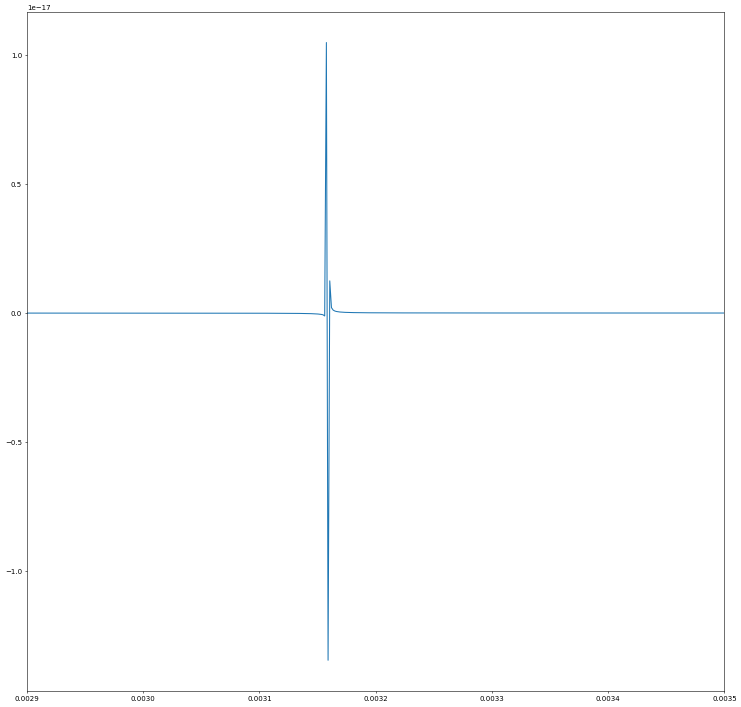

In [187]:
fig1=plt.figure(figsize=(18,18),dpi=50)

Mc=10*m_sun
Smr=0.25
x=np.linspace(-4.0,-2.0,10000)
fu=np.power(10.0,x)
work1=hreal(fu)*h_mod(fu,Mc,Smr).real+himag(fu)*h_mod(fu,Mc,Smr).imag
work2=hreal(fu)*h_mod(fu,Mc,Smr).imag-himag(fu)*h_mod(fu,Mc,Smr).real
work3=himag(fu)
work4=h_mod(fu,Mc,Smr).real*100
work5=h_mod(fu,Mc,Smr).imag
work6=hreal(fu)*h_mod(fu,Mc,Smr).real
work7=abs(h_mod(fu,Mc,Smr))*100
work8=hs(fu)
plt.plot(fu,h_modreal(fu))
#plt.plot(fu,work8)
#plt.yscale('log')
#plt.xscale('log')
plt.xlim(0.0029,0.0035)
plt.show()

In [180]:
m_1=10.0*m_sun
m_2=10.0*m_sun
a_0=3.0e8
k_1=k_1cal(m_1,m_2)
N=5000000
t_scale=4*years
t=np.linspace(0,t_scale,num=N)
T=t_scale/N
fs=1.0/T
y_mod=hmod_plus(t,k_1,a_0,m_1,m_2)
print 1
xs=np.linspace(0,1/2.0/T,num=N//2)
yff=fft.fft(y)
y_mod_abs=abs(yff)*1.0e8
y_mods=np.zeros((N//2,), dtype=np.float64)
y_mods=2.0/N*y_abs[0:N//2]
h_mods=sci_interpolate.interp1d(xs,ys,kind='cubic')
h_modr1=2.0/N*yff.real[0:N//2]*1.0e8
h_modi1=2.0/N*yff.imag[0:N//2]*1.0e8
h_modreal=sci_interpolate.interp1d(xs,hr1,kind='cubic')
h_modimag=sci_interpolate.interp1d(xs,hi1,kind='cubic')
np.sqrt(sci_integrate.quad(lambda x:2.0*(h_modr1(x)*hr1(x)+h_modi1(x)*hi1(x))/S_n_lisa(x),1.0e-4,0.01))

1


array([ 3.76311103,  1.55161925])

In [191]:
sci_integrate.quad(lambda x:2.0*(hreal(x)*h_modreal(x)+himag(x)*h_modimag(x))/S_n_lisa(x),1.0e-4,0.01)

(6.255219618002697, 1.834527049238588)

In [35]:
i2=5
i3=5
N3=15
N4=0
datadraw=np.zeros((66,3))
while i2<N3+1:
    i3=5
    while i3<i2+1:
        datadraw[N4,0]=Mc_sun
        datadraw[N4,1]=Smr
        datadraw[N4,2]=FF
        print(i2*0.1,i3*0.1,N4),' '
        i3=i3+1
        N4=N4+1
    i2=i2+1
print N4

(0.5, 0.5, 0)  
(0.6000000000000001, 0.5, 1)  
(0.6000000000000001, 0.6000000000000001, 2)  
(0.7000000000000001, 0.5, 3)  
(0.7000000000000001, 0.6000000000000001, 4)  
(0.7000000000000001, 0.7000000000000001, 5)  
(0.8, 0.5, 6)  
(0.8, 0.6000000000000001, 7)  
(0.8, 0.7000000000000001, 8)  
(0.8, 0.8, 9)  
(0.9, 0.5, 10)  
(0.9, 0.6000000000000001, 11)  
(0.9, 0.7000000000000001, 12)  
(0.9, 0.8, 13)  
(0.9, 0.9, 14)  
(1.0, 0.5, 15)  
(1.0, 0.6000000000000001, 16)  
(1.0, 0.7000000000000001, 17)  
(1.0, 0.8, 18)  
(1.0, 0.9, 19)  
(1.0, 1.0, 20)  
(1.1, 0.5, 21)  
(1.1, 0.6000000000000001, 22)  
(1.1, 0.7000000000000001, 23)  
(1.1, 0.8, 24)  
(1.1, 0.9, 25)  
(1.1, 1.0, 26)  
(1.1, 1.1, 27)  
(1.2000000000000002, 0.5, 28)  
(1.2000000000000002, 0.6000000000000001, 29)  
(1.2000000000000002, 0.7000000000000001, 30)  
(1.2000000000000002, 0.8, 31)  
(1.2000000000000002, 0.9, 32)  
(1.2000000000000002, 1.0, 33)  
(1.2000000000000002, 1.1, 34)  
(1.2000000000000002, 1.2000000000000002,

In [45]:
i2=5
i3=5
N3=15
N4=0
datadraw12=np.zeros((66,3))
while i2<N3+1:
    i3=5
    while i3<i2+1:
        
        datadraw12[N4,0]=0.1*i2
        datadraw12[N4,1]=0.1*i3
        datadraw12[N4,2]=datadraw[N4,2]
        #print(i2*0.1,i3*0.1)
        i3=i3+1
        N4=N4+1
    i2=i2+1

In [49]:
datadraw12[:,2].max()

0.019772069486952662

In [134]:
np.savetxt('datadraw.txt',datadraw)
np.savetxt('datadraw12.txt',datadraw12)

In [44]:
datadraw

array([[  4.35275282e+00,   2.50000000e-01,   5.81759934e-04],
       [  4.76424641e+00,   2.47933884e-01,   6.46115418e-03],
       [  5.22330338e+00,   2.50000000e-01,   3.98003179e-04],
       [  5.13575831e+00,   2.43055556e-01,   4.69024966e-04],
       [  5.63846519e+00,   2.48520710e-01,   3.12196586e-04],
       [  6.09385394e+00,   2.50000000e-01,   7.11273798e-03],
       [  5.47579681e+00,   2.36686391e-01,   1.06623034e-03],
       [  6.01892782e+00,   2.44897959e-01,   1.54626791e-02],
       [  6.51170270e+00,   2.48888889e-01,   8.77759152e-04],
       [  6.96440451e+00,   2.50000000e-01,   1.06103810e-03],
       [  5.79031114e+00,   2.29591837e-01,   8.73698682e-04],
       [  6.37115255e+00,   2.40000000e-01,   7.41185906e-04],
       [  6.89890768e+00,   2.46093750e-01,   1.30779857e-03],
       [  7.38430648e+00,   2.49134948e-01,   2.40176858e-03],
       [  7.83495507e+00,   2.50000000e-01,   1.19482383e-02],
       [  6.08364342e+00,   2.22222222e-01,   4.3070802

In [130]:
help(plt.imshow)

Help on function imshow in module matplotlib.pyplot:

imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, shape=None, filternorm=1, filterrad=4.0, imlim=None, resample=None, url=None, hold=None, data=None, **kwargs)
    Display an image on the axes.
    
    Parameters
    ----------
    X : array_like, shape (n, m) or (n, m, 3) or (n, m, 4)
        Display the image in `X` to current axes.  `X` may be an
        array or a PIL image. If `X` is an array, it
        can have the following shapes and types:
    
        - MxN -- values to be mapped (float or int)
        - MxNx3 -- RGB (float or uint8)
        - MxNx4 -- RGBA (float or uint8)
    
        The value for each component of MxNx3 and MxNx4 float arrays
        should be in the range 0.0 to 1.0. MxN arrays are mapped
        to colors based on the `norm` (mapping scalar to scalar)
        and the `cmap` (mapping the normed scalar to a color).
    
    cm

In [22]:
abs(h_mod(0.01, chirp_mass(m_sun,m_sun),0.25))

3.4044125425978556e+27

In [23]:
hs(0.01)

array(2.821016556537508e-30)

In [27]:
r

3.085144207108599e+23

In [37]:
time.clock()

454.033749

In [38]:
time.clock()

454.046049

In [11]:
Mc

1.7316121254523135e+31

In [10]:
t1=time.clock()
Mc=chirp_mass(m_1,m_2)
Mc_sun=Mc/m_sun
Smr=sym_mass_ratio(m_1,m_2)
A=np.sqrt(sci_integrate.quad(lambda x:4.0*np.power(hs(x),2.0)/S_n_lisa(x)*1.0e110,1.0e-4,0.01))
B=np.sqrt(sci_integrate.quad(lambda x:4.0*np.power(abs(h_mod(x,Mc,Smr)),2.0)/S_n_lisa(x),1.0e-4,0.01))
AB=sci_integrate.quad(lambda x:4.0*np.power(hn2(x))/S_n_lisa(x),1.0e-7,0.01)
FF=abs(AB[0]/A[0]/B[0])
t2=time.clock()
print '(A,DelA)=',A,'(B,DelB)=',B,'(AB,DelAB)=',AB,'FF=',AB[0]/A[0]/B[0],'(Mc/m_sun,Smr)',(Mc_sun,Smr),(t2-t1)*10000/60/60


NameError: global name 'hn2' is not defined

In [127]:
t1=time.clock()
Mc=chirp_mass(m_1,m_2)
Mc_sun=Mc/m_sun
Smr=sym_mass_ratio(m_1,m_2)
A=np.sqrt(sci_integrate.quad(lambda x:4.0*np.power(hs(x),2.0)/S_n_lisa(x),1.0e-4,0.01))
B=np.sqrt(sci_integrate.quad(lambda x:4.0*np.power(abs(h_mod(x,Mc,Smr)),2.0)/S_n_lisa(x),1.0e-4,0.01))

fu=np.linspace(0.0001,0.01,100000)

work1=hreal(fu)*h_mod(fu,Mc,Smr).real+himag(fu)*h_mod(fu,Mc,Smr).imag
work2=hreal(fu)*h_mod(fu,Mc,Smr).imag-himag(fu)*h_mod(fu,Mc,Smr).real

work3


t2=time.clock()
print '(A,DelA)=',A,'(B,DelB)=',B,'(AB,DelAB)=',0,'FF=',1/A[0]/B[0],'(Mc/m_sun,Smr)',(Mc_sun,Smr),(t2-t1)*10000/60/60




(A,DelA)= [ 12.81914475   1.19332606] (B,DelB)= [  1.29332287e+00   9.44058926e-05] (AB,DelAB)= 0 FF= 0.0603162027516 (Mc/m_sun,Smr) (8.7055056329612057, 0.25) 3.82233888889


In [106]:
work1=(yff.real[1:N/2]*h_mod(xs,Mc,Smr)[1:N/2].real+yff.imag[1:N/2]*h_mod(xs,Mc,Smr).imag[1:N/2])+1j*(yff.real[1:N/2]*h_mod(xs,Mc,Smr).imag[1:N/2]-yff.imag[1:N/2]*h_mod(xs,Mc,Smr).real[1:N/2])
work2=fft.fft(work1)
work3=abs(work2).max()

/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in power
/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in divide
/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply


In [339]:
fumax=yn2(fu).max()

In [138]:
A=np.sqrt(sci_integrate.quad(lambda x:4.0*np.power(hs(x),2.0)/S_n_lisa(x),1.0e-4,0.01))
B=np.sqrt(sci_integrate.quad(lambda x:4.0*np.power(abs(h_mod(x,Mc,Smr)),2.0)/S_n_lisa(x),1.0e-4,0.01))
A,B

(array([ 12.81914475,   1.19332606]),
 array([  3.67673070e+00,   2.68382361e-04]))

In [139]:
f1=time.clock()
Nfu=5000
fu=np.linspace(1e-4,1e-2,Nfu)
i=0
work1=np.zeros(Nfu)
work2=np.zeros(Nfu)
while i<Nfu:
    work1[i]=(hreal(fu[i])*h_mod(fu[i],Mc,Smr).real+himag(fu[i])*h_mod(fu[i],Mc,Smr).imag)/S_n_lisa(fu[i])
    work2[i]=(hreal(fu[i])*h_mod(fu[i],Mc,Smr).imag-himag(fu[i])*h_mod(fu[i],Mc,Smr).real)/S_n_lisa(fu[i])
    i=i+1
work3=fft.fft(work1+1.0j*work2)
work4=abs(work3)*2/Nfu
work4max=2.0*work4.max()
f2=time.clock()
print work4max,f1-f2

115.413102749 -22.354812


i2=5
i3=5
N3=15
N4=0
datadraw=np.zeros((66,3))
while i2<N3+1:
    i3=5
    while i3<i2+1:
        Mc=chirp_mass(i2*m_sun,i3*m_sun)
        Mc_sun=Mc/m_sun
        Smr=sym_mass_ratio(i2*m_sun,i3*m_sun)
        B=np.sqrt(sci_integrate.quad(lambda x:4.0*np.power(abs(h_mod(x,Mc,Smr)),2.0)/S_n_lisa(x),1.0e-5,0.01))
        A=np.sqrt(sci_integrate.quad(lambda x:4.0*np.power(hs(x),2.0)/S_n_lisa(x),1.0e-5,0.01))
        AB=sci_integrate.quad(lambda x:4.0*(hreal(x)*h_mod(x,Mc,Smr).real+himag(x)*h_mod(x,Mc,Smr).imag)/S_n_lisa(x),1.0e-5,0.01)
        FF=abs(AB[0]/A[0]/B[0])
        datadraw[N4,0]=Mc_sun
        datadraw[N4,1]=Smr
        datadraw[N4,2]=FF
        print(i2*0.1,i3*0.1,N4),' '
        i3=i3+1
        N4=N4+1
    i2=i2+1
print N4

In [ ]:
i2=5
i3=5
N3=15
N4=0
df=6.0/10000
x=np.linspace(-4.0,-2.0,3000)
datadraw=np.zeros((66,3))
while i2<N3+1:
    i3=5
    while i3<i2+1:
        Mc=chirp_mass(i2*m_sun,i3*m_sun)
        Mc_sun=Mc/m_sun
        Smr=sym_mass_ratio(i2*m_sun,i3*m_sun)
        B=np.sqrt(sci_integrate.quad(lambda x:4.0*np.power(abs(h_mod(x,Mc,Smr)),2.0)/S_n_lisa(x),1.0e-5,0.01))
        A=np.sqrt(sci_integrate.quad(lambda x:4.0*np.power(hs(x),2.0)/S_n_lisa(x),1.0e-5,0.01))
        
        ans=0.0
        for i4 in x:
            fu=np.power(10.0,i4)
            ans=ans+(hreal(fu)*h_mod(fu,Mc,Smr).real+himag(fu)*h_mod(fu,Mc,Smr).imag)/S_n_lisa(fu)*df*np.log(10)*fu
        FF=abs(ans/A[0]/B[0])
        datadraw[N4,0]=Mc_sun
        datadraw[N4,1]=Smr
        datadraw[N4,2]=FF
        print(i2*0.1,i3*0.1,N4),' '
        i3=i3+1
        N4=N4+1
    i2=i2+1
print N4